In [16]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import seaborn as sns
from tqdm import tqdm
from dataclasses import dataclass, field
from mpl_toolkits.mplot3d import Axes3D 
sns.set(style = "white")
import warnings
warnings.filterwarnings("ignore")

- No closed form solution
- GD (cost function, cost derivative)
- Sigmoid
- predict
- add column 0
- the data we are going to use already has train and test split, so we need a dataReader

Inputs:
- learning rate
- tolerance
- max_iterations

In [66]:
@dataclass
class LogisticRegression:
    learning_rate: float
    tolerance: float
    max_iterations: int = 50000
    indices_to_remove: list[int] = field(default_factory=list)


    def remove_index(self,i):
        self.train_df1 = self.train_df1.drop(index=i)

    def add_x0(self, X):
        return np.column_stack([np.ones([X.shape[0], 1]), X])       

    def data_reader(self):
        self.train_df1 = pd.read_excel('Lab3_data.xls', sheet_name = '2004--2005 Data')
        test_df = pd.read_excel('Lab3_data.xls', sheet_name = '2004--2007 Data')
        
        print(len(self.train_df1))

        for index in self.indices_to_remove:
            self.remove_index(index)

        print(len(self.train_df1))
        
        train_df = np.array(self.train_df1, dtype = np.float64)
        test_df = np.array(test_df, dtype = np.float64)

        # train_df = self.add_x0(train_df)
        # test_df = self.add_x0(test_df)
    

        X_train, y_train = train_df[:, 1:], train_df[:, 0]
        X_test, y_test = test_df[:, 1:], test_df[:, 0]
        return X_train, X_test, y_train, y_test

        


    def sigmoid(self,z):
        return 1/(1 + np.exp(-z))

    def cost_function(self, X, y):
        sig = self.sigmoid(X.dot(self.w))
        cost = y * np.log(sig) + (1 - y) * np.log(1 - sig)
        cost = - cost.sum()
        return cost

    def gradient(self, X, y):
        sig = self.sigmoid(X.dot(self.w))
        grad = (sig - y).dot(X)
        return grad

    def gradient_descent(self, X, y):
        errors = []
        last_error = float('inf') #inf = infinte
        for i in tqdm(range(self.max_iterations)):
            self.w = self.w - self.learning_rate * self.gradient(X, y)
            curr_error = self.cost_function(X, y)
            diff = last_error - curr_error
            last_error = curr_error
            errors.append(last_error)

            if diff < self.tolerance:
                print("Model has stoppend learning")
                break
        self.plot_cost(errors)

    def plot_cost(self,cost_sequence):
        
        s = np.array(cost_sequence)
        t = np.arange(s.size)
        
        fig, ax = plt.subplots()
        ax.plot(t,s)
        
        ax.set(xlabel = 'iterations', ylabel = 'cost' , title = 'cost trend')
        ax.grid()
        plt.legend(bbox_to_anchor=(1.05,1), loc=2,shadow=True)
        plt.show()

    def predict(self, X):
        sig = self.sigmoid(X.dot(self.w))
        return np.around(sig)

    def evaluate(self, y, y_hat):
        y = (y == 1) # converts y to boolean by doing element wise comparison and assigns true for all y == 1
        y_hat = (y_hat == 1)
                
        accuracy = (y == y_hat).sum() / len(y) # no.of times model predicted1 amd zero correctly by total points
        precision = (y & y_hat).sum() / y_hat.sum()
        recall = (y & y_hat).sum() / y.sum()

        return accuracy, precision, recall

    def fit(self):
        self.X_train, self.X_test, self.y_train, self.y_test = self.data_reader()
        self.X_train = self.add_x0(self.X_train)
        self.X_test = self.add_x0(self.X_test)
        self.w = np.ones(self.X_train.shape[1], dtype=np.float64)

        self.gradient_descent(self.X_train, self.y_train)
        print(self.w)
        y_hat_train = self.predict(self.X_train)

        accuracy, precision, recall = self.evaluate(self.y_train, y_hat_train)
        print("Accuracy is:", accuracy)
        print("Precision is:", precision)
        print("Recall is:", recall)
    
    def plot(self):
        plt.figure(figsize=(12,8))
        ax = plt.axes(projection='3d')

        # Data for three-dimensional scattered points
        ax.scatter3D(self.X_train[:, 1], self.X_train[:, 2], 
                     self.sigmoid(self.X_train.dot(self.w)), 
                     c = self.y_train[:], cmap='viridis', s=100);

        ax.set_xlim3d(55, 80)
        ax.set_ylim3d(80, 240)
        plt.xlabel('$x_1$ feature', fontsize=15)
        plt.ylabel('$x_2$ feature', fontsize=15, )
        ax.set_zlabel('$P(Y = 1|x_1, x_2)$', fontsize=15, rotation = 0)

    
    
    def scatterPlt(self):
        # evenly sampled points
        x_min, x_max = 55, 80
        y_min, y_max = 80, 240

        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 250),
                             np.linspace(y_min, y_max, 250))
        grid = np.c_[np.ones((xx.ravel().shape[0],)), xx.ravel(), yy.ravel()]
        #grid = np.c_[xx.ravel(), yy.ravel()]
        probs = grid.dot(self.w).reshape(xx.shape)

        f, ax = plt.subplots(figsize=(14,12))


        ax.contour(xx, yy, probs, levels=[0.5], cmap="Greys", vmin=0, vmax=.6)


        ax.scatter(self.X_train[:, 1], self.X_train[:, 2], 
                   c=self.y_train[:], s=50,
                   cmap="RdBu", vmin=-.2, vmax=1.2,
                   edgecolor="white", linewidth=1)

        plt.xlabel('x1 feature')
        plt.ylabel('x2 feature')
        

    def plot3D(self):
        # evenly sampled points
        x_min, x_max = 55, 80
        y_min, y_max = 80, 240
        
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 250),
                             np.linspace(y_min, y_max, 250))
        
        #grid = np.c_[xx.ravel(), yy.ravel()]
        grid = np.c_[np.ones((xx.ravel().shape[0],)), xx.ravel(), yy.ravel()]
        probs = grid.dot(self.w).reshape(xx.shape)
        fig = plt.figure(figsize=(14,12))
        ax = plt.axes(projection='3d')
        ax.contour3D(xx, yy, probs, 50, cmap='binary')

        ax.scatter3D(self.X_train[:, 1], self.X_train[:, 2], 
                   c=self.y_train[:], s=50,
                   cmap="RdBu", vmin=-.2, vmax=1.2,
                   edgecolor="white", linewidth=1)

        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('probs')
        ax.set_title('3D contour')
        plt.show()
        
        
        
        

In [67]:
lr = LogisticRegression(tolerance = 0.00001, learning_rate = 0.00001, indices_to_remove = [0,38])

46
44


100%|██████████| 50000/50000 [00:00<00:00, 87782.76it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


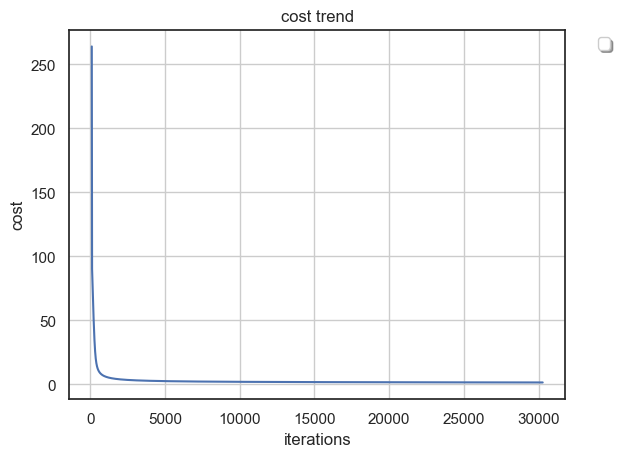

[ 0.9234997  -1.13844634  0.54337081]
Accuracy is: 1.0
Precision is: 1.0
Recall is: 1.0


In [68]:
lr.fit()

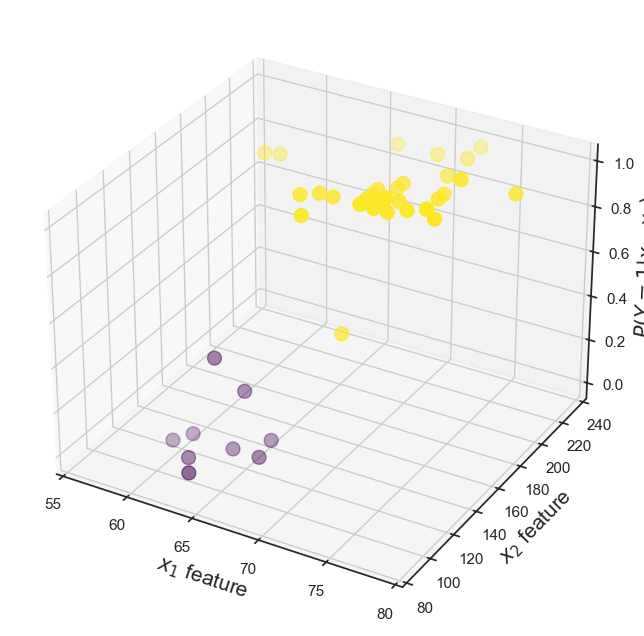

In [69]:
lr.plot()

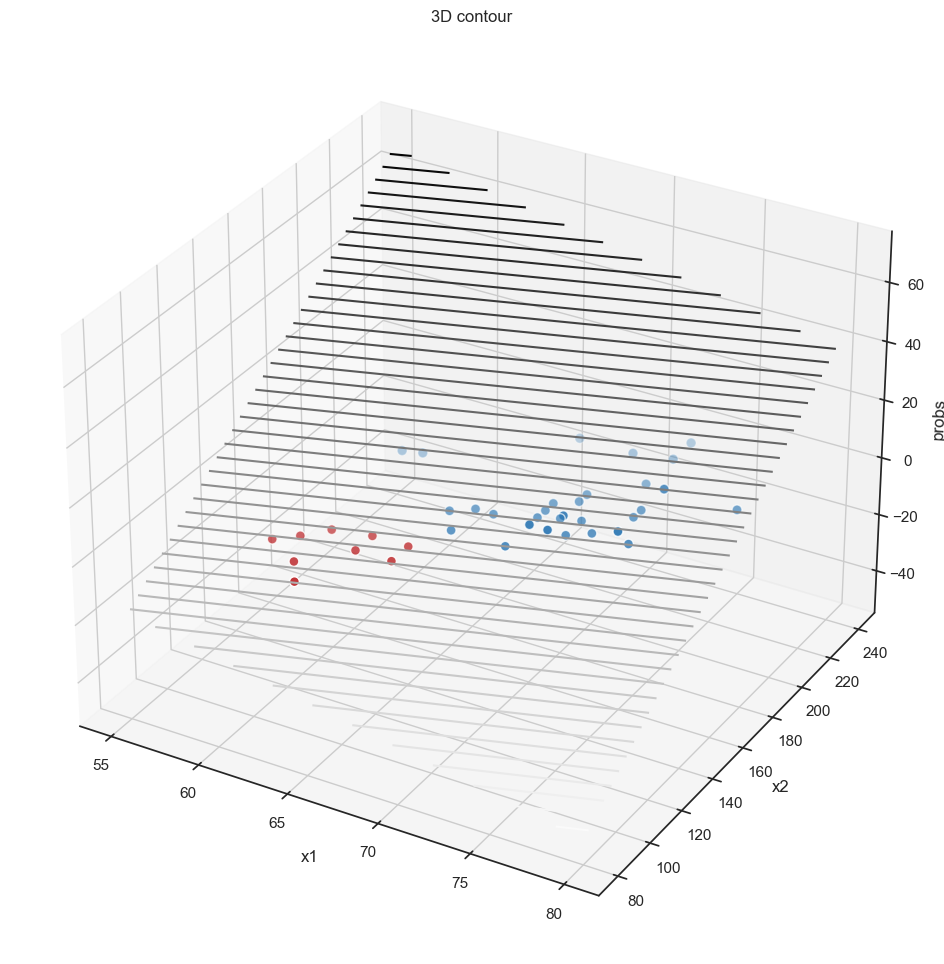

In [70]:
lr.plot3D()

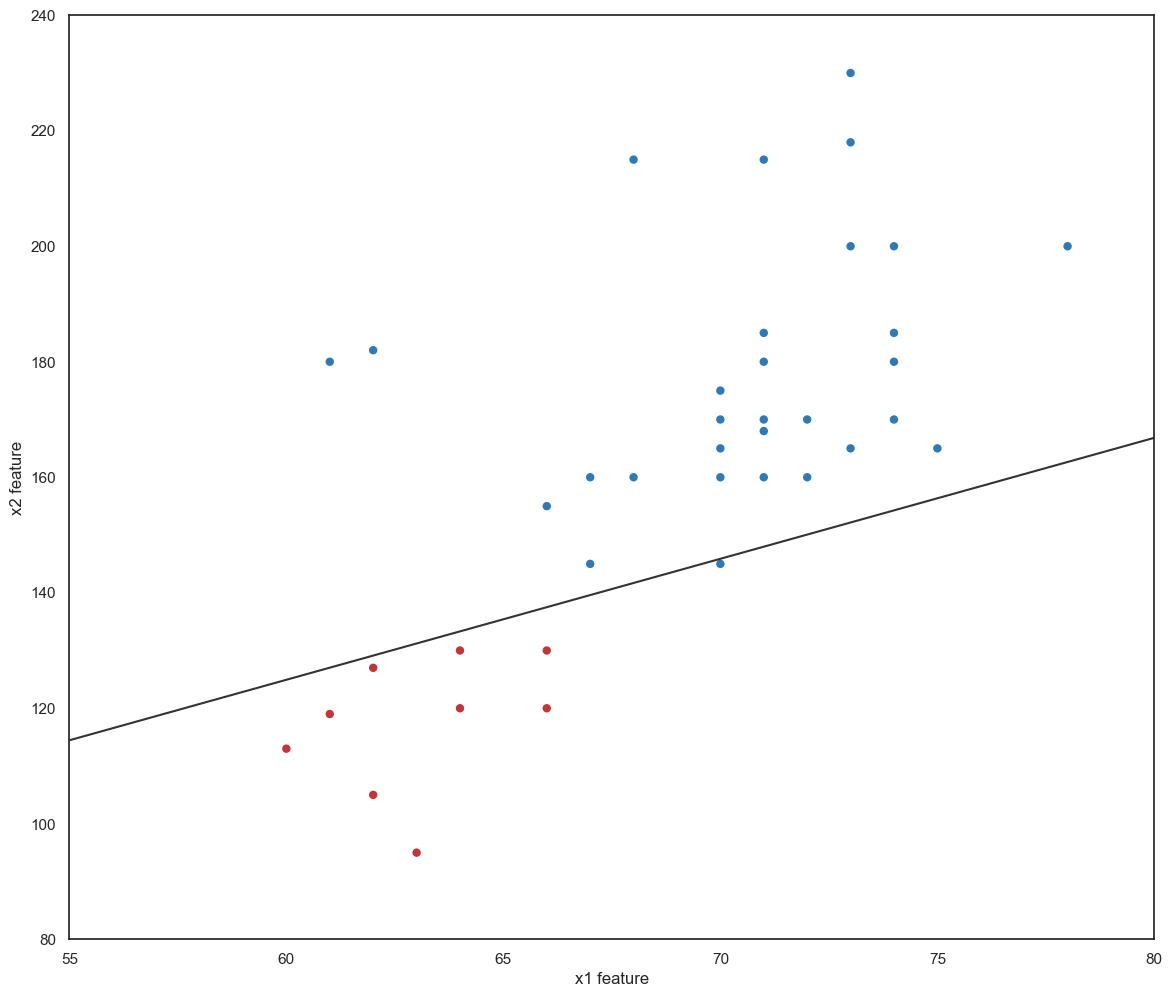

In [65]:
lr.scatterPlt()